# RAG Agent

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma

embedding_function = OpenAIEmbeddings()

docs = [
    Document(
        page_content="Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.",
        metadata={"source": "owner.txt"},
    ),
    Document(
        page_content="Bella Vista offers a range of dishes with prices that cater to various budgets. Appetizers start at $8, main courses range from $15 to $35, and desserts are priced between $6 and $12.",
        metadata={"source": "dishes.txt"},
    ),
    Document(
        page_content="Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.",
        metadata={"source": "restaurant_info.txt"},
    ),
    Document(
        page_content="Bella Vista offers a variety of menus including a lunch menu, dinner menu, and a special weekend brunch menu. The lunch menu features light Italian fare, the dinner menu offers a more extensive selection of traditional and contemporary dishes, and the brunch menu includes both classic breakfast items and Italian specialties.",
        metadata={"source": "restaurant_info.txt"},
    ),
]

db = Chroma.from_documents(docs, embedding_function)
retriever = db.as_retriever(search_kwargs={"k": 2})

In [3]:
# !pip install langchain-groq

In [4]:
from langchain import hub
from langchain_groq import ChatGroq

prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(model="gpt-4o-mini")
# llm5 = ChatGroq(model="models/qwen-qwq-32b")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt | llm

/opt/anaconda3/envs/adamenv/lib/python3.12/site-packages/langsmith/client.py:278: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [5]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain.schema import Document

class AgentState(TypedDict):
    messages: list[BaseMessage]
    documents: list[Document]
    on_topic: str

In [6]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

class GradeQuestion(BaseModel):
    """Boolean value to check whether a question is related to the restaurant Bella Vista"""

    score : str = Field(
        description = "Question is about restaurant? If yes -> 'Yes' if not -> 'No' "
    )

def question_classifier(state: AgentState):
    question = state["messages"][-1].content

    system = """You are a classifier that determines whether a user's question is about one of the following topics:

    1. Information about the owner of Bella Vista, which is Antonio Rossi.
    2. Information about the dishes served at Bella Vista (restaurant).
    3. Information about the opening hours of Bella Vista (restaurant).

    If the question IS about any of these topics, answer with 'Yes'. If the question is NOT about any of these topics, answer with 'No'. 
    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: {question}"),
        ]
    )

    llm = ChatOpenAI(model="gpt-4o-mini")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})
    print("RESULT", result)
    state["on_topic"] = result.score
    return state

In [7]:
def on_topic_router(state):
    on_topic = state["on_topic"]
    if on_topic.lower() == "yes":
        return "on_topic"
    else:
        return "off_topic"

def retrieve(state):
    question = state["messages"][-1].content
    documents = retriever.invoke(question)
    state["documents"] = documents
    return state

def generate_answer(state):
    question = state["messages"][-1].content
    documents = state["documents"]
    generation = rag_chain.invoke({"context": documents, "question":question})
    state["messages"].append(generation)
    return state

def off_topic_response(state: AgentState):
    state["messages"].append(AIMessage(content="Sorry, I can't respond to that, it's not about my field of expertise."))
    return state

In [8]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate_answer", generate_answer)

workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router,
    {
        "on_topic": "retrieve",
        "off_topic": "off_topic_response",
    },
)

workflow.add_edge("retrieve", "generate_answer")
workflow.add_edge("generate_answer", END)
workflow.add_edge("off_topic_response", END)

workflow.set_entry_point("topic_decision")
graph = workflow.compile()

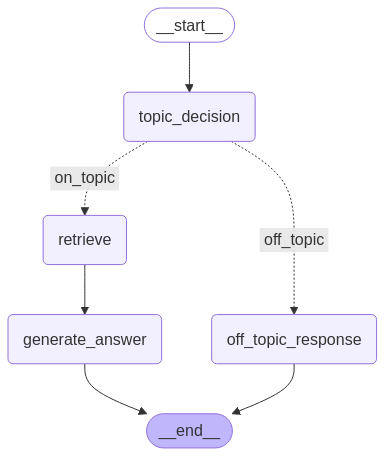

In [9]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [10]:
graph.invoke(input={"messages": [HumanMessage(content="When does the bella vista restaurant open?")]})

RESULT score='Yes'


{'messages': [HumanMessage(content='When does the bella vista restaurant open?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Bella Vista restaurant is open from Monday to Sunday. Weekday hours are from 11:00 AM to 10:00 PM, and weekend hours are from 11:00 AM to 11:00 PM.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 198, 'total_tokens': 243, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BLC1oFuePc7OKeXKk00timP8DbWoi', 'finish_reason': 'stop', 'logprobs': None}, id='run-a6c39429-1495-4fbd-916f-c28504f8ed61-0', usage_metadata={'input_tokens': 198, 'output_tokens': 45, 'total_tokens': 243, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'out

In [11]:
graph.invoke(input={"messages": [HumanMessage(content="What is artificial intelligence?")]})

RESULT score='No'


{'messages': [HumanMessage(content='What is artificial intelligence?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Sorry, I can't respond to that, it's not about my field of expertise.", additional_kwargs={}, response_metadata={})],
 'on_topic': 'No'}

## Retrieval with Tools

In [46]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_tool",
    "Information related to Pricing, Opening hours of the owner of the restaurant Bella Vista",
)


@tool
def off_topic():
    """Catch all Questions NOT related to Pricing, Opening hours of the owner of the restaurant Bella Vista"""
    print("messages_tool =", state["messages"])
    return "Forbidden - do not respond to the user"


tools = [retriever_tool, off_topic]

In [47]:
from typing import Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [48]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

def agent(state):
    messages = state["messages"]
    print("messages =", state["messages"])
    model = ChatOpenAI(model="gpt-4o-mini")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}

def should_continue(state) -> Literal["tools",END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    else:
        return END

In [49]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

workflow = StateGraph(AgentState)
tool_node = ToolNode(tools)

workflow.add_node("agent", agent)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools","agent")

graph = workflow.compile()

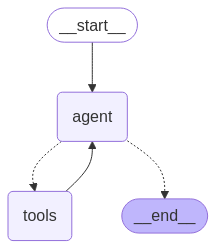

In [50]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

In [51]:
graph.invoke(input={"messages": [HumanMessage(content="How will the weather be tommorrow?")]})

messages = [HumanMessage(content='How will the weather be tommorrow?', additional_kwargs={}, response_metadata={}, id='d5e611ed-23f6-4d49-97c8-22d62431dbad')]
messages = [HumanMessage(content='How will the weather be tommorrow?', additional_kwargs={}, response_metadata={}, id='d5e611ed-23f6-4d49-97c8-22d62431dbad'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_41a6tCA5qMNYNVlfSuljHCVU', 'function': {'arguments': '{}', 'name': 'off_topic'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 99, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_80cf447eee', 'id': 'chatcmpl-BLGRdWb1wNStvAGbfhPSONpEo3HEN', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run

{'messages': [HumanMessage(content='How will the weather be tommorrow?', additional_kwargs={}, response_metadata={}, id='d5e611ed-23f6-4d49-97c8-22d62431dbad'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_41a6tCA5qMNYNVlfSuljHCVU', 'function': {'arguments': '{}', 'name': 'off_topic'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 99, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_80cf447eee', 'id': 'chatcmpl-BLGRdWb1wNStvAGbfhPSONpEo3HEN', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-770c2acc-0d14-4222-9137-e4cc09557ffb-0', tool_calls=[{'name': 'off_topic', 'args': {}, 'id': 'call_41a6tCA5qMNYNVlfSuljHCVU', 'type': 'tool_call'}], usage

In [43]:
graph.invoke(input={"messages": [HumanMessage(content="When does the bella vista restaurant open?")]})

messages = [HumanMessage(content='When does the bella vista restaurant open?', additional_kwargs={}, response_metadata={}, id='0dea49e8-a0d2-4db4-b3e3-f3c6f6d7a836')]
messages = [HumanMessage(content='When does the bella vista restaurant open?', additional_kwargs={}, response_metadata={}, id='0dea49e8-a0d2-4db4-b3e3-f3c6f6d7a836'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6BRJCIlt2zOegR1m7YKFM46A', 'function': {'arguments': '{"query":"opening hours of the Bella Vista restaurant"}', 'name': 'retriever_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 98, 'total_tokens': 121, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_80cf447eee', 'id': 'chatcmpl-BLGQCXwDwSjcg55

{'messages': [HumanMessage(content='When does the bella vista restaurant open?', additional_kwargs={}, response_metadata={}, id='0dea49e8-a0d2-4db4-b3e3-f3c6f6d7a836'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6BRJCIlt2zOegR1m7YKFM46A', 'function': {'arguments': '{"query":"opening hours of the Bella Vista restaurant"}', 'name': 'retriever_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 98, 'total_tokens': 121, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_80cf447eee', 'id': 'chatcmpl-BLGQCXwDwSjcg559Yz8NtTpnETt89', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c5309194-56ce-497c-91de-945bf051aff6-0', tool_calls=[{'name': 'retriever_tool', 'args': 